In [59]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import taosws
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

The following code establishes the connection to the TDEngine database, assuming TDEngine has domain name `td-1` and has the default port, username and password.

In [60]:
# Global Variables
dsn = "http+ws://172.16.105.238:6041"
conn = taosws.connect(dsn=dsn)
database = "TraceLogs"

The following functions describe which data are available.
1. <code>get_digitizer_indices_from_table_names()</code> returns an integer list with all digitizer indices found from the database.
From hereon `digitizer_id`s are synonymous with digitizer indices.
2. <code>get_digitizer_frames(digitizer_id)</code> returns a dataframe with all metadata associated with the given digitizer.

The following code prints out a table with the number of frames available for each digitizer.

In [61]:
def get_digitizer_indices_from_table_names():
    list = [int(tbl[1:]) for tbl in pd.read_sql(f"show {database}.tables", conn)["table_name"] if tbl[0] == "d"]
    list.sort()
    return list

def get_digitizer_frames(digitizer_id):
    df = pd.read_sql(f"SELECT * FROM {database}.m{digitizer_id}", conn)
    #df["frame_ts"] = pd.to_datetime(df["frame_ts"], infer_datetime_format = True)
    return df

digitizer_indices = get_digitizer_indices_from_table_names()
digitizer_frame_count = [len(get_digitizer_frames(index)) for index in digitizer_indices]
df = pd.DataFrame([digitizer_frame_count], ["Frame Count"], digitizer_indices)
print(tabulate(df, headers='keys', tablefmt='rounded_grid'))

╭─────────────┬─────╮
│             │   2 │
├─────────────┼─────┤
│ Frame Count │ 792 │
╰─────────────┴─────╯


The following code examines the metadata for each frame in `digitizer_id` more carefully.
1. `frame_ts` is the timestamp of the first sample of the frame. This is the primary key used to identify the frame uniquely (along with the `digitizer_id`).
1. `sample_count` is the number of samples in the frame.
1. `frame_number` is what the frame calls itself.
1. `has_error` determines whether an error occured when inserting the frame into the database.
More details can be found in the log file of the `trace-archiver-db` program. The correct error can be found by corrolating with `frame_ts` and `digitizer_id`.
1. `cidn`: is the id of the nth channel. This should be unique accross all digitizers.

In [62]:
digitizer_id = 2
df_digitizer_info = get_digitizer_frames(digitizer_id)
df_digitizer_info["frame_ts"] = pd.to_datetime(df_digitizer_info["frame_ts"])
print(tabulate(df_digitizer_info,headers="keys", tablefmt='rounded_grid'))

# For some reason the sample counts of some frames are 1. This needs to be resolved at some point.


╭─────┬───────────────────────────────┬────────────────┬─────────────────┬────────────────┬──────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│     │ frame_ts                      │   sample_count │   sampling_rate │   frame_number │   error_code │   cid0 │   cid1 │   cid2 │   cid3 │   cid4 │   cid5 │   cid6 │   cid7 │
├─────┼───────────────────────────────┼────────────────┼─────────────────┼────────────────┼──────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│   0 │ 2023-11-24 11:29:52.079179086 │          10000 │      1000000000 │            529 │            4 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │
├─────┼───────────────────────────────┼────────────────┼─────────────────┼────────────────┼──────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│   1 │ 2023-11-24 11:29:52.099356890 │          10000 │      1000000000 │            530 │            4 

The following function extract unique timestamp of a frame, and the index of a channel, from their respective identifiers.
1. <code>get_frame_timestamp_from_number(digitizer_id, frame_number)</code> extracts the unique timestamp for the frame in `digitizer_id` whose `frame_number` corresponds the the given <code>frame_number</code>.
1. <code>get_channel_index_from_id(digitizer_id, frame_timestamp, channel)</code> extracts the index for the channel in the frame with timestamp <code>frame_timestamp</code> in <code>digitizer_id</code> whose ```cidn``` corresponds the the given <code>channel</code>.

The following code prints data for the given choices of <code>frame_id</code> and <code>channel_id</code>.

In [63]:
def get_frame_timestamp_from_number(digitizer_id, frame_number):
    df_digitizer_info = get_digitizer_frames(digitizer_id)
    df_digitizer_info = df_digitizer_info[df_digitizer_info["frame_number"] == frame_number]
    if df_digitizer_info.empty:
        raise Exception("No frames with given frame_number found.")
    else:
        return df_digitizer_info.iloc[0]["frame_ts"]


def get_channel_index_from_id(digitizer_id, frame_timestamp, channel):
    df_digitizer_info = get_digitizer_frames(digitizer_id)
    df_digitizer_info = df_digitizer_info[df_digitizer_info["frame_ts"]==frame_timestamp]
    if df_digitizer_info.empty:
        raise Exception("No frames with given timestamp found.")
    else:
        for i in range(8):
            if df_digitizer_info.iloc[0][f"cid{i}"] == channel:
                return i
        raise Exception("No channel with given id.")

frame_number = 142
channel_id = 0

frame_timestamp = get_frame_timestamp_from_number(digitizer_id, frame_number)
channel_index = get_channel_index_from_id(digitizer_id, frame_timestamp, channel_id)

print(f"Digitizer {digitizer_id}:\n  (frame_number, channel_id) = ({frame_number}, {channel_id}) =>\n  (frame timestamp, channel index) = ({frame_timestamp}, {channel_index})")

Digitizer 2:
  (frame_number, channel_id) = (142, 0) =>
  (frame timestamp, channel index) = (1700825637971897664, 0)


<code>display_digitizer_frame_channel(digitizer_id, frame_timestamp, channel)</code> displays a plot of the samples in <code>channel</code>, for the frame with timestamp <code>frame_timestamp</code>, in digitizer <code>digitizer_id</code>.

The following code executes this with the previous choices of <code>channel_index</code>, <code>frame_timestamp</code>, and <code>digitizer_id</code>.

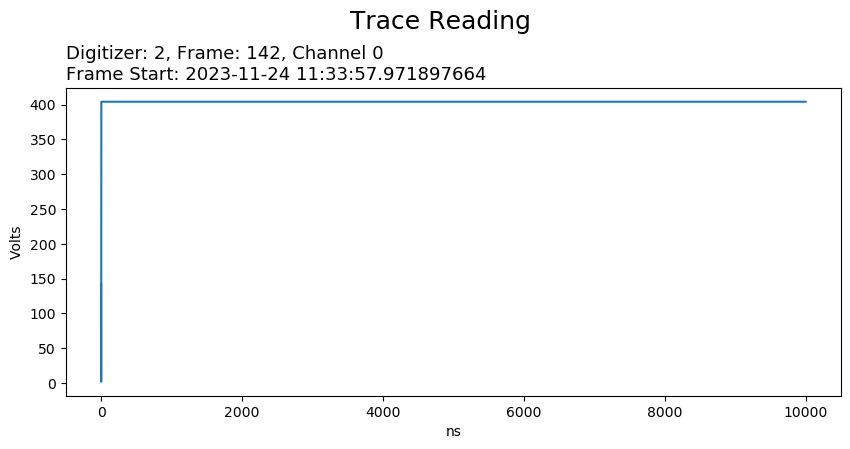

In [64]:
def display_digitizer_frame_channel(digitizer_id, frame_timestamp, channel_index):
    df_frame = get_digitizer_frames(digitizer_id)
    df_frame = df_frame[df_frame["frame_ts"]==frame_timestamp].iloc[0]

    frame_timestamp_end = frame_timestamp + int(df_frame["sample_count"]*(df_frame["sampling_rate"]/1000000000))

    sql = f"SELECT ts, c{channel_index} FROM {database}.d{digitizer_id} WHERE ts BETWEEN {frame_timestamp} AND {frame_timestamp_end}"
    df = pd.read_sql(sql, conn)
    ns = [t - frame_timestamp for t in df["ts"]]

    (fig, _) = plt.subplots(nrows=1, ncols=1, figsize = (10,4))
    ax = plt.subplot(1,1, 1, xlabel = "ns", ylabel = "Volts")
    plt.plot(ns, df[f"c{channel_index}"].to_list())
    plt.suptitle(f"Trace Reading", fontsize=18, y= 1.075)
    line1 = f"Digitizer: {digitizer_id}, Frame: {df_frame['frame_number']}, Channel {df_frame[f'cid{channel_index}']}"
    line2 = f"Frame Start: {pd.to_datetime(frame_timestamp)}"
    plt.title(f"{line1}\n{line2}",fontsize=13, y = 1.00, ha="left", x = 0.0)

display_digitizer_frame_channel(digitizer_id, frame_timestamp,channel_index)

Call the `display_digitizer_frame(digitizer_id, frame_index)` function to show all eight channel traces for the selected digitizer and frame.

The following code executes this useing the previous choices of <code>frame_timestamp</code>, and <code>digitizer_id</code>.

In [65]:
def display_digitizer_frame(digitizer_id, frame_timestamp):
    df_frame = get_digitizer_frames(digitizer_id)
    df_frame = df_frame[df_frame["frame_ts"]==frame_timestamp].iloc[0]
    sql = f"SELECT ts, c0, c1, c2, c3, c4, c5, c6, c7 FROM {database}.d{digitizer_id} WHERE frametime = {df_frame['frame_ts']}"
    df = pd.read_sql(sql, conn)
    ns = [t - df_frame['frame_ts'] for t in df["ts"]]
    min_voltage = min([df[f"c{channel}"].min() for channel in range(8)])
    max_voltage = max([df[f"c{channel}"].max() for channel in range(8)])

    (fig, _) = plt.subplots(nrows=4, ncols=2, figsize = (14,12))
    plt.subplots_adjust(hspace = 0.5)
    for channel in range(8):
        ax = plt.subplot(4,2, channel + 1, xlabel = "ns", ylabel = "Volts", ylim = (min_voltage, max_voltage))
        ax.set_title(f"Channel {df_frame[f'cid{channel}']}", fontsize = "12")
        plt.plot(ns, df[f"c{channel}"].to_list())
    
    fig.suptitle(f"Trace Reading", fontsize=18)
    line1 = f"Digitizer: {digitizer_id}, Frame: {df_frame['frame_number']}"
    line2 = f"Frame Start: {pd.to_datetime(df_frame['frame_ts'])}"
    fig.text(0.15, 0.9125, f"{line1}\n{line2}",fontsize=13, horizontalalignment="left")

display_digitizer_frame(digitizer_id, frame_timestamp)

DatabaseError: Execution failed on sql 'SELECT ts, c0, c1, c2, c3, c4, c5, c6, c7 FROM TraceLogs.d2 WHERE frametime = 1700825637971897664': [0x2602] Internal error: `Invalid column name: frametime`

Keep your system tidy. Closes the network.

In [ ]:
conn.close()